<a href="https://colab.research.google.com/github/jimmy-io/Insight_project/blob/master/keras_maskrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Insight/Project

/content/drive/My Drive/Insight/Project


In [0]:
!pip install keras-retinanet

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=156787 sha256=98dcc9f463b18fa1b3e7389365d3be7c74bc9431ba50874ed481510d91963084
  Stored in directory: /root/.cache/pip/wheels/d9/a5/98/87f8ed08913b184bb625dde1c1277a4dfe969c77b377abde69
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20485 sha256=fac5e26781a0b616435495b43fa7b7a45048cac6c5116b94c4734c96a34e105f
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet


In [0]:
!pip install keras-maskrcnn

  Created wheel for keras-maskrcnn: filename=keras_maskrcnn-0.2.2-cp36-none-any.whl size=41692 sha256=7be28a798940ae11ff072e36abd9ea20131b564e2f741aaba76d61f9b9a066c5
  Stored in directory: /root/.cache/pip/wheels/0b/03/0e/652a317641021f3450b92b69567e64cc54597d71e809426be8
Successfully built keras-maskrcnn


In [3]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_maskrcnn import models
from keras_maskrcnn.utils.visualization import draw_mask
from keras_retinanet.utils.visualization import draw_box, draw_caption, draw_annotations
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [4]:
cd '/content/drive/My Drive/Insight/Project/MAsk-RCNN'

/content/drive/My Drive/Insight/Project/MAsk-RCNN


In [8]:
# adjust this to point to your downloaded/trained model
model_path = os.path.join('/content/drive/My Drive/Insight/Project/MAsk-RCNN', 'resnet50_coco_v0.2.0.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
box_ind is deprecated, use box_indices instead






/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


processing time:  13.58646035194397


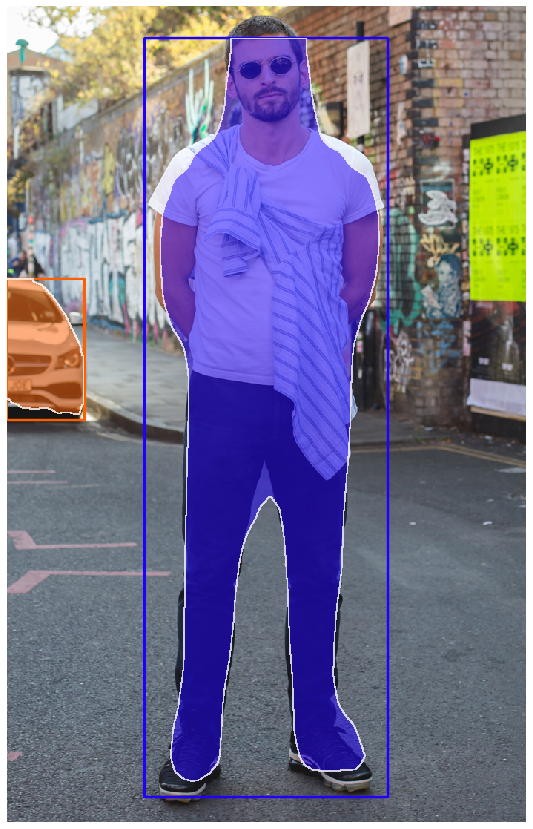

In [11]:
# load image
image = read_image_bgr('2019hannahsept27.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
outputs = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

boxes  = outputs[-4][0]
scores = outputs[-3][0]
labels = outputs[-2][0]
masks  = outputs[-1][0]

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label, mask in zip(boxes, scores, labels, masks):
    if score < 0.5:
        break

    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    mask = mask[:, :, label]
    draw_mask(draw, b, mask, color=label_color(label))
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    #draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [10]:
pwd

'/content/drive/My Drive/Insight/Project/MAsk-RCNN'